<a href="https://colab.research.google.com/github/JasperAD11/Sentiment-Across-Signals-Neural-Networks-vs.-LLMs/blob/main/project_ATPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TO DO**:
  1. Compute results for other models (change parameters) and compare.
  2. Code doesn't run for the second model

**Doubts**:
  1. what if the same word appears 2x in the same review/newswire, is that explicit in the tensor?

# Project: Part 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import imdb    # imdb is a dataset with reviews (encoded in numbers)
from tensorflow.keras import layers

In [3]:
# Set a fixed random seed value
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

## Model 1: Binary sentiment classification

### Dataset
(using imdb inside tensorflow.keras.datasets)

In [4]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
# keeping only the 10000 most frequent word

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


#### not necessary

Both train_data and test_data are **lists with nested lists inside**, each of the nested lists is a review, where each word is casted into a number.
(each word in the dictionary is equivalente to a specific number)

In [5]:
train_data[:2]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

Both train_labels and test_labels are lists of 0/1 label, where 0=negative review and 1=positive review.

In [6]:
train_labels[8]

np.int64(1)

Extra: decoding back to natural laguage


In [7]:
word_index = imdb.get_word_index()    # dict that maps each word to its code number

reverse_word_index = dict(            # dict inverting value and key (number to word)
    [(value, key) for (key, value) in word_index.items()])

# Decoding train_data[0]
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

decoded_review

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

### Turning the list of words(numbers) into tensors

The underlying idea is that we want to have a matrix with 10000 columns (one for each of the top10000 words) and a row for each review.


In [8]:
def vectorize_sequences(sequences, dimension=10000):     # dimension=10000 because there are 10000 different words
  results = np.zeros((len(sequences), dimension))      # starting with a tensor of all 0.(s)
  for i, sequence in enumerate(sequences):
    for j in sequence:                                # j is each index inside a nested list in data = each word in a review
      results[i, j] = 1.                            # inside a tensor inside "results", 1. is that word appers
  return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# After the transformation above, each review is now a RANK-1 TENSOR with 10000 dimensions.
# After the transformation above, each train/test_data is now a RANK-2 TENSOR with 10000 dimensions.

# x_train[0]

Similarly, we need to vectorize labels. For that, we do the following:

In [9]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### CNN model

Choosing the architecture of the model:

In [10]:
max_features = 10000   # Define maximum number of words to consider in the vocabulary
maxlen = 500           # Define sequence length (truncate or pad sequences to this length)
embedding_dim = 128    # Embedding dimension

# Create the model
model_cnn = keras.Sequential([
    # Embedding layer to convert word indices to dense vectors
    layers.Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen),

    # 1D CNN layers for extracting n-gram features
    layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=5),
    layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=5),
    layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    layers.GlobalMaxPooling1D(),

    # Dense layers for classification
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add dropout to reduce overfitting
    layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# model.compile(optimizer="rmsprop",            # choosing optimizer
#               loss="binary_crossentropy",     # choosing loss function
#               metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
# Splitting train into partial_train and validation
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Let's now train the model.

In [21]:
history = model_cnn.fit(partial_x_train,                       # history is an 'History' object
                          partial_y_train,
                          epochs=5,
                          batch_size=512,
                          validation_data=(x_val, y_val))

Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.5066 - loss: 0.6932 - val_accuracy: 0.4947 - val_loss: 0.6933
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.4980 - loss: 0.6932 - val_accuracy: 0.4947 - val_loss: 0.6933
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5064 - loss: 0.6931 - val_accuracy: 0.4947 - val_loss: 0.6933
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.4992 - loss: 0.6934 - val_accuracy: 0.4947 - val_loss: 0.6933
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5053 - loss: 0.6931 - val_accuracy: 0.4947 - val_loss: 0.6933


In [13]:
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 10000, 128)     │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 10000, 128)     │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2000, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 400, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 400, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,628,357 (17.66 MB)

 Trainable params: 1,542,785 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,085,572 (11.77 MB)

In [14]:
# History objects have a member 'history' that is a dict
history_dict = history.history

history_dict.keys()
# history_dict.values()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

#### Plotting:

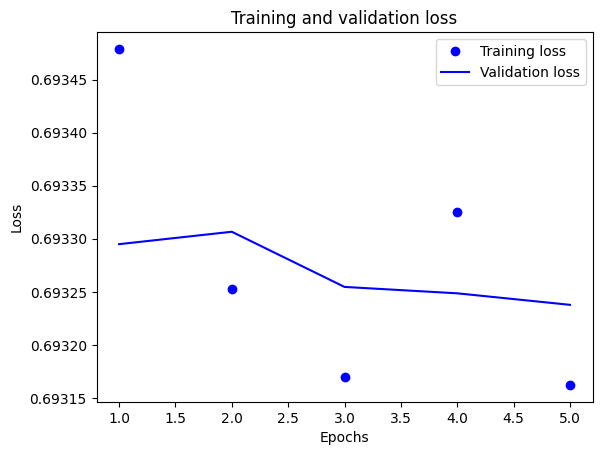

In [15]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

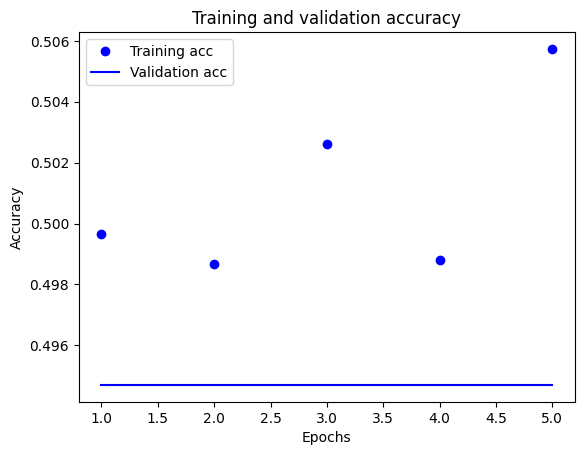

In [16]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### LSTM model

In [28]:
# Define parameters
max_features = 10000  # Size of vocabulary
maxlen = 500  # Max sequence length
embedding_dim = 128  # Embedding dimension

# Create the LSTM model
model_lstm = keras.Sequential([
    # Embedding layer converts integer indices to dense vectors
    layers.Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen),

    # Bidirectional LSTM to process sequence in both directions
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),

    # Second LSTM layer for deeper representation
    layers.Bidirectional(layers.LSTM(32)),

    # Dropout for regularization
    layers.Dropout(0.5),

    # Dense hidden layer
    layers.Dense(64, activation='relu'),

    # Output layer for binary classification
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [23]:
# Splitting train into partial_train and validation
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [ ]:
history = model_lstm.fit(partial_x_train,                       # history is an 'History' object
                          partial_y_train,
                          epochs=20,
                          batch_size=32,
                          validation_data=(x_val, y_val))

Epoch 1/20
439/469 ━━━━━━━━━━━━━━━━━━━━ 27s 928ms/step - accuracy: 0.4832 - loss: 0.6939

In [24]:
model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# History objects have a member 'history' that is a dict
history_dict = history.history

history_dict.keys()
# history_dict.values()

#### Plotting:

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Final model

Retraining the model in all the train data and evaluation in test data.
After that we are computing the results.

In [ ]:
# Train the model
history = model_lstm.fit(
    x_train, y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
        keras.callbacks.ModelCheckpoint('best_lstm_model.h5', save_best_only=True)
    ]
)

In [ ]:
model = keras.Sequential([
    ])

model.compile(optimizer=,
              loss=,
              metrics=)

model.fit(x_train, y_train, epochs=4, batch_size=512)

results = model.evaluate(x_test, y_test)

results

Making predictions:

In [ ]:
model.predict(x_test)

### Can we improve the model? How?

We experiment different architecture:
1. Add another layer / Take out one layer.
2. Increse/Decrease perceptrons inside layers (usualy factors of 8: 32, 64, 128).
3. Try 'mse' for loss function.
4. Try 'tanh' for activation function.

##  Model 2: Multi-class emotion detection

In [ ]:
from tensorflow.keras.datasets import reuters   # Dataset with news labeled with a topic

### Dataset

(using reuters dataset inside tensorflow.keras.datasets)

In [ ]:
(train_data, train_labels),(test_data, test_labels) = reuters.load_data(num_words = 100000)
# again we are only interested in the TOP10000 words

#### not necessary

In [ ]:
len(train_data)

In [ ]:
len(test_data)

In [ ]:
len(train_labels)

Note that the format of the data is the same as in the previous case, where each piece of news is encode into a list of integers, being each of them correspondent to a word.

Extra: decoding back to word (same as in imdb case)

In [ ]:
word_index = reuters.get_word_index()    # dict that maps each word to its code number

reverse_word_index = dict(            # dict inverting value and key (number to word)
    [(value, key) for (key, value) in word_index.items()])

# Decoding train_data[0]
decoded_newswire = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

decoded_newswire

### Turning lists into tensors (same code as before)

In [ ]:
# Dont understand this error
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [ ]:
# Vectorizing labels (diferent than in the previous case because there are more than 2 labels)

def to_one_hot(labels, dimension=46):
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1.
  return results

# this yields a matrix with 46 dimensions(columns),
# where all values in a row are 0 except in the column with the number of the correct label

y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [ ]:
# There is all this built in way to do it
# from tensorflow.keras.utils import to_categorical
# y_train = to_categorical(train_labels)
# y_test = to_categorical(test_labels)

### CNN model

In [ ]:
max_features = 10000   # Define maximum number of words to consider in the vocabulary
maxlen = 500           # Define sequence length (truncate or pad sequences to this length)
embedding_dim = 128    # Embedding dimension

# Create the model
model_cnn = keras.Sequential([
    # Embedding layer to convert word indices to dense vectors
    layers.Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen),

    # 1D CNN layers for extracting n-gram features
    layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=5),
    layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=5),
    layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    layers.GlobalMaxPooling1D(),

    # Dense layers for classification
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add dropout to reduce overfitting
    layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# model.compile(optimizer="rmsprop",            # choosing optimizer
#               loss="binary_crossentropy",     # choosing loss function
#               metrics=["accuracy"])

Let's compute validation datasets.

In [ ]:
# Splitting train into partial_train and validation
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Let's now train the model

In [ ]:
history = model_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

#### Plotting

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Transformer model

In [ ]:
# Define parameters
max_features = 10000  # Size of vocabulary
maxlen = 500  # Max sequence length
embedding_dim = 128  # Embedding dimension

# Transformer block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=head_size
    )(inputs, inputs)
    attention_output = layers.Dropout(dropout)(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(
        inputs + attention_output
    )

    # Feed-forward network
    ffn_output = layers.Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout)(ffn_output)

    # Second residual connection and layer normalization
    return layers.LayerNormalization(epsilon=1e-6)(
        attention_output + ffn_output
    )

# Define input
inputs = layers.Input(shape=(maxlen,))

# Embedding layer
x = layers.Embedding(max_features, embedding_dim)(inputs)

# Add positional encoding
positions = tf.range(start=0, limit=maxlen, delta=1)
position_embedding = layers.Embedding(
    input_dim=maxlen, output_dim=embedding_dim
)(positions)
x = x + position_embedding

# Apply dropout
x = layers.Dropout(0.1)(x)

# Apply transformer blocks
transformer_blocks = 2
for _ in range(transformer_blocks):
    x = transformer_encoder(x, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)

# Pool across sequence dimension and apply classification layers
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Build the model
model_transf = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model_transf.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Train the model
history = model_transf.fit(
    x_train, y_train,
    batch_size=32,
    epochs=5,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
        keras.callbacks.ModelCheckpoint('best_transformer_model.h5', save_best_only=True)
    ]
)

In [ ]:
model_transf.summary()

In [ ]:
# Evaluate on test set
test_loss, test_acc = model_transf.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')
"""

### Final model

In [ ]:
# what does this do?
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

Making predictions:

In [ ]:
predictions = model.predict(x_test)